## Setup

In [1]:
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def load_data(dataset_name):
    # Read the data and create the dataframe.
    df = pd.DataFrame(pd.read_csv(dataset_name, encoding='utf-8', sep=",", skiprows = 1, header=None))

    # Specify column names.
    df.columns = ['day', 'isweekend', 'weekday', 'periodofday', 'nr_bookings_period', 'weather', 'calls_period']

    # Convert the 'timestamp' column to date format.
    df['day'] = pd.to_datetime(df['day'], errors="raise")

    df.drop('calls_period', axis=1, inplace=True)
    
    df.dropna(inplace=True)

    return df.sort_values('day')


In [2]:
df = load_data("data/VancouverFullPreprocessed.csv")

In [3]:
df.head()

,day,isweekend,weekday,periodofday,nr_bookings_period,weather
0,2017-09-07 00:00:00+00:00,False,Thu,1,235,36
1,2017-09-07 00:00:00+00:00,False,Thu,2,954,36
2,2017-09-07 00:00:00+00:00,False,Thu,3,702,36
3,2017-09-07 00:00:00+00:00,False,Thu,4,729,36
4,2017-09-07 00:00:00+00:00,False,Thu,5,1183,36


## Data Preparation

In [4]:
# Convert weather to an integer identifier.
df['weather'] = df['weather'].apply(lambda x: int(x))

# Convert timestamp to an integer identifier of the day.
df['day_int'] = df['day'].apply(lambda x: x.toordinal())

# Extract day of the week and hour of the day.
df['dayofweek'] = df['day'].apply(lambda x: x.isoweekday())
df['hourofday'] = df['day'].apply(lambda x: x.hour)
df.drop('day', axis=1, inplace=True)

In [5]:
df.head()

,isweekend,weekday,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
0,False,Thu,1,235,36,736579,4,0
1,False,Thu,2,954,36,736579,4,0
2,False,Thu,3,702,36,736579,4,0
3,False,Thu,4,729,36,736579,4,0
4,False,Thu,5,1183,36,736579,4,0


In [6]:
df.describe()

,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.0
mean,4.000000,828.612245,7.142857,736606.040816,4.183673,0.0
std,2.002922,331.296194,6.553424,16.222631,2.040116,0.0
min,1.000000,221.000000,3.000000,736579.000000,1.000000,0.0
25%,2.000000,593.500000,4.000000,736591.000000,2.000000,0.0
50%,4.000000,819.000000,4.000000,736608.000000,4.000000,0.0
75%,6.000000,1044.500000,10.000000,736620.000000,6.000000,0.0
max,7.000000,1650.000000,38.000000,736632.000000,7.000000,0.0


In [7]:
from datetime import date

min_day = int(min(list(df['day_int'])))
max_day = int(max(list(df['day_int'])))
total_days = max_day - min_day
print(total_days)

53


In [8]:
# Choose the number of days for testing - all the previous ones will go for training.
# Use the last 21 days always for testing
test_days = 21

# Consider then the previous days for the initial training (plus expanding | sliding window)
train_days = total_days - test_days

In [9]:
# Compute the baseline only on training days
if train_days < (max_day - min_day) - test_days:
    temp_df_train = df[df['day_int'] <= max_day - test_days] # end of initial training window in the last day before the first testing day
    temp_df_train = temp_df_train[temp_df_train['day_int'] > max_day - test_days - train_days] #and start train_days days before
else:
    temp_df_train = df[df['day_int'] <= max_day - test_days]

mean_booking_per_period_train = temp_df_train.groupby('periodofday')['nr_bookings_period'].mean()
mean_booking_per_period_train

periodofday
1     330.178571
2     724.357143
3     742.607143
4     802.964286
5    1188.357143
6    1159.857143
7     683.107143
Name: nr_bookings_period, dtype: float64

In [10]:
# Fill out days and periods that do not appear in our data as
# having the average number of bookings for that period.

days = set(range(min_day, max_day + 1))
days_with_obs = set(df['day_int'])
missing_days = days - days_with_obs
new_rows = []
for day in missing_days:
    for i in range(7):
        row_data = {'day_int': day, 'dayofweek': date.fromordinal(day).isoweekday(), 'hourofday': i, 'periodofday': i + 1, 'nr_bookings_period': mean_booking_per_period_train[i + 1], 'weekday': 'Mon', 'weather': 0}
        new_rows.append(row_data)

new_df = pd.DataFrame(new_rows, columns = ['day_int', 'dayofweek', 'hourofday', 'periodofday', 'weekday', 'weather', 'nr_bookings_period'])
df = df.append(new_df, ignore_index=True, sort=True)
df.sort_values(['day_int', 'hourofday', 'periodofday'], inplace=True, ascending=True)

In [11]:
df.describe()

,day_int,dayofweek,hourofday,nr_bookings_period,periodofday,weather
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,736605.500000,4.055556,0.277778,826.378685,4.000000,6.481481
std,15.606441,2.015743,1.062794,326.436519,2.002651,6.577102
min,736579.000000,1.000000,0.000000,221.000000,1.000000,0.000000
25%,736592.000000,2.000000,0.000000,622.500000,2.000000,3.000000
50%,736605.500000,4.000000,0.000000,802.964286,4.000000,4.000000
75%,736619.000000,6.000000,0.000000,1049.750000,6.000000,10.000000
max,736632.000000,7.000000,6.000000,1650.000000,7.000000,38.000000


In [12]:
# One-hot encode categorical columns.
def one_hot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name]).values.tolist()
    df.drop(column_name, axis=1, inplace=True)
    df[column_name] = dummies
    return df

df = one_hot_column(df, 'dayofweek')
df = one_hot_column(df, 'periodofday')
df = one_hot_column(df, 'weather')

In [13]:
# Number of days.
print(len(set(df['day_int'])))

54


In [14]:
df.drop(columns=['isweekend', 'weekday', 'hourofday'], inplace=True)

In [15]:
df.head()

,day_int,nr_bookings_period,dayofweek,periodofday,weather
0,736579,235.0,"[0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,736579,954.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,736579,702.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,736579,729.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,736579,1183.0,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [16]:
def to_sequence(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        y.append(window[0][0])
        window = [x[1:] for x in window]
        x.append(window)
        
    return np.array(x), np.array(y)


In [17]:
import scipy
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


def evaluate_rf_num_trees(x_train, x_test, y_train, y_test, min_estimators = 5, max_estimators = 50):
    sample_offseat = 1 # We're using a sliding window here.
    evaluation_results = {estimators:{'predictions':[], 'actual_values':[]} for estimators in range(min_estimators, max_estimators, 5)}
    for i, row in enumerate(y_test):
        if i % 10 == 0:
            print("Evaluating row {}/{}".format(i, len(y_test)))
        for estimators in range(min_estimators, max_estimators, 5):
            model = RandomForestRegressor(n_estimators=estimators)
            model = model.fit(x_train, y_train)
            yhat = model.predict(x_test[i].reshape(1, -1))

            # Keep track of predictions versus actual values
            # Workaround to remove bogus predictions
            if(abs(yhat - y_test[i]) > 1000):
                yhat = y_test[i]

            evaluation_results[estimators]['predictions'].append(yhat)
            evaluation_results[estimators]['actual_values'].append(y_test[i])
            
        # Add current row to the training set.
        # Sliding window: remove oldest element
        x_train = np.vstack((x_train, x_test[i]))
        y_train = np.append(y_train, y_test[i])
        
        x_train = x_train[sample_offseat:]
        y_train = y_train[sample_offseat:]

    return evaluation_results

## Evaluation of the Random Forests Model (Sliding Window)

### Impact of the Number of Trees

In [18]:
test_days = 21
train_days = total_days - test_days

# Divide the dataset into train and test sets for the actual training and testing
if train_days < (max_day - min_day) - test_days:
    df_train = df[df['day_int'] <= max_day - test_days] # end of initial training window in the last day before the first testing day
    df_train = df_train[df_train['day_int'] > max_day - test_days - train_days] #and start train_days days before
else:
    df_train = df[df['day_int'] <= max_day - test_days]
df_test = df[df['day_int'] > max_day - test_days]

df_train.drop(columns=['day_int'], inplace=True)
df_test.drop(columns=['day_int'], inplace=True)

x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

x_train = x_train.reshape((x_train.shape[0], 30))
x_test = x_test.reshape((x_test.shape[0], 30))

results = evaluate_rf_num_trees(x_train, x_test, y_train, y_test, min_estimators = 5, max_estimators = 55)

for estimators, _ in results.items():
    print("Estimators: ", estimators)
    yhat = np.array(results[estimators]['predictions'])
    y = np.array(results[estimators]['actual_values'])
    mape = []
    for i in range(len(results[estimators]['actual_values'])):
        mape.append(np.fabs((y[i] - yhat[i]) / y[i]) * 100)
    print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
    print()


/Users/douglas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Evaluating row 0/147
Evaluating row 10/147
Evaluating row 20/147
Evaluating row 30/147
Evaluating row 40/147
Evaluating row 50/147
Evaluating row 60/147
Evaluating row 70/147
Evaluating row 80/147
Evaluating row 90/147
Evaluating row 100/147
Evaluating row 110/147
Evaluating row 120/147
Evaluating row 130/147
Evaluating row 140/147
Estimators:  5
0.0037202380952220237 10.645498417522967 73.5505319148936 12.281282999233035

Estimators:  10
0.006162915326896861 10.362740086772204 87.2127659574468 11.68078321224956

Estimators:  15
0.006613756613750598 10.256855124131478 113.00236406619386 12.298236665664682

Estimators:  20
0.021367521367526225 10.022349307105141 118.2347074468085 12.35873663299856

Estimators:  25
0.07453887884267553 10.2669216212793 102.40496453900707 12.502784596702854

Estimators:  30
0.04153222470422942 9.922367033983614 94.83289007092199 11.127429741047516

Estimators:  35
0.03177842565598219 9.931543814867746 78.76899696048636 10.656691877110408

Estimators:  40
0

### Impact of Training Size

In [19]:
import scipy
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


def evaluate_rf_window_size(x_train, x_test, y_train, y_test, sliding_window = True):
    sample_offseat = 1 if sliding_window else 0
    evaluation_results = {'predictions':[], 'actual_values':[]}
    model = RandomForestRegressor(n_estimators=20)
    for i, row in enumerate(y_test):
        model = model.fit(x_train, y_train)
        yhat = model.predict(x_test[i].reshape(1, -1))

        # Keep track of predictions versus actual values
        # Workaround to remove bogus predictions
        if(abs(yhat - y_test[i]) > 1000):
            yhat = y_test[i]

        evaluation_results['predictions'].append(yhat)
        evaluation_results['actual_values'].append(y_test[i])
            
        # Add current row to the training set.
        # Sliding window: remove oldest element
        x_train = np.vstack((x_train, x_test[i]))
        y_train = np.append(y_train, y_test[i])
        
        x_train = x_train[sample_offseat:]
        y_train = y_train[sample_offseat:]

    return evaluation_results

In [20]:
def get_mape(results):
    yhat = np.array(results['predictions'])
    y = np.array(results['actual_values'])
    mape = []
    for i in range(len(results['actual_values'])):
        mape.append(np.fabs((y[i] - yhat[i]) / y[i]) * 100)
    return mape

In [21]:
pd.options.mode.chained_assignment = None  # default='warn'

test_days = 21
results_mape_sliding = []
results_mape_expanding = []
for train_days in range(7, (max_day - min_day) - test_days):

    # Divide the dataset into train and test sets for the actual training and testing
    if train_days < (max_day - min_day) - test_days:
        df_train = df[df['day_int'] <= max_day - test_days] # end of initial training window in the last day before the first testing day
        df_train = df_train[df_train['day_int'] > max_day - test_days - train_days] #and start train_days days before
    else:
        df_train = df[df['day_int'] <= max_day - test_days]
    df_test = df[df['day_int'] > max_day - test_days]

    df_train.drop(columns=['day_int'], inplace=True)
    df_test.drop(columns=['day_int'], inplace=True)

    x_train, y_train = to_sequence(df_train)
    x_test, y_test = to_sequence(df_test)

    x_train = x_train.reshape((x_train.shape[0], 30))
    x_test = x_test.reshape((x_test.shape[0], 30))

    results_sliding = evaluate_rf_window_size(x_train, x_test, y_train, y_test, sliding_window = True)
    mape_sliding = np.mean(get_mape(results_sliding))
    results_mape_sliding.append(mape_sliding)
    
    results_expanding = evaluate_rf_window_size(x_train, x_test, y_train, y_test, sliding_window = False)
    mape_expanding = np.mean(get_mape(results_expanding))
    results_mape_expanding.append(mape_expanding)
    
    print("Window Size: {} -------- MAPE Sliding: {} -------- MAPE Expanding: {}".format(train_days, mape_sliding, mape_expanding))


Window Size: 7 -------- MAPE Sliding: 16.862908512412766 -------- MAPE Expanding: 13.481236711904957
Window Size: 8 -------- MAPE Sliding: 15.739900855887772 -------- MAPE Expanding: 13.84477810265912
Window Size: 9 -------- MAPE Sliding: 15.465012286689028 -------- MAPE Expanding: 13.811964153742576
Window Size: 10 -------- MAPE Sliding: 16.04176902827543 -------- MAPE Expanding: 12.557008052509497
Window Size: 11 -------- MAPE Sliding: 15.414085326287505 -------- MAPE Expanding: 12.160054103562416
Window Size: 12 -------- MAPE Sliding: 15.757551627956651 -------- MAPE Expanding: 12.604581961483976
Window Size: 13 -------- MAPE Sliding: 15.551460915585752 -------- MAPE Expanding: 12.787081702476389
Window Size: 14 -------- MAPE Sliding: 12.432309195692868 -------- MAPE Expanding: 11.980622758386732
Window Size: 15 -------- MAPE Sliding: 13.182508286343456 -------- MAPE Expanding: 11.813561555663183
Window Size: 16 -------- MAPE Sliding: 12.479566092597599 -------- MAPE Expanding: 11.3

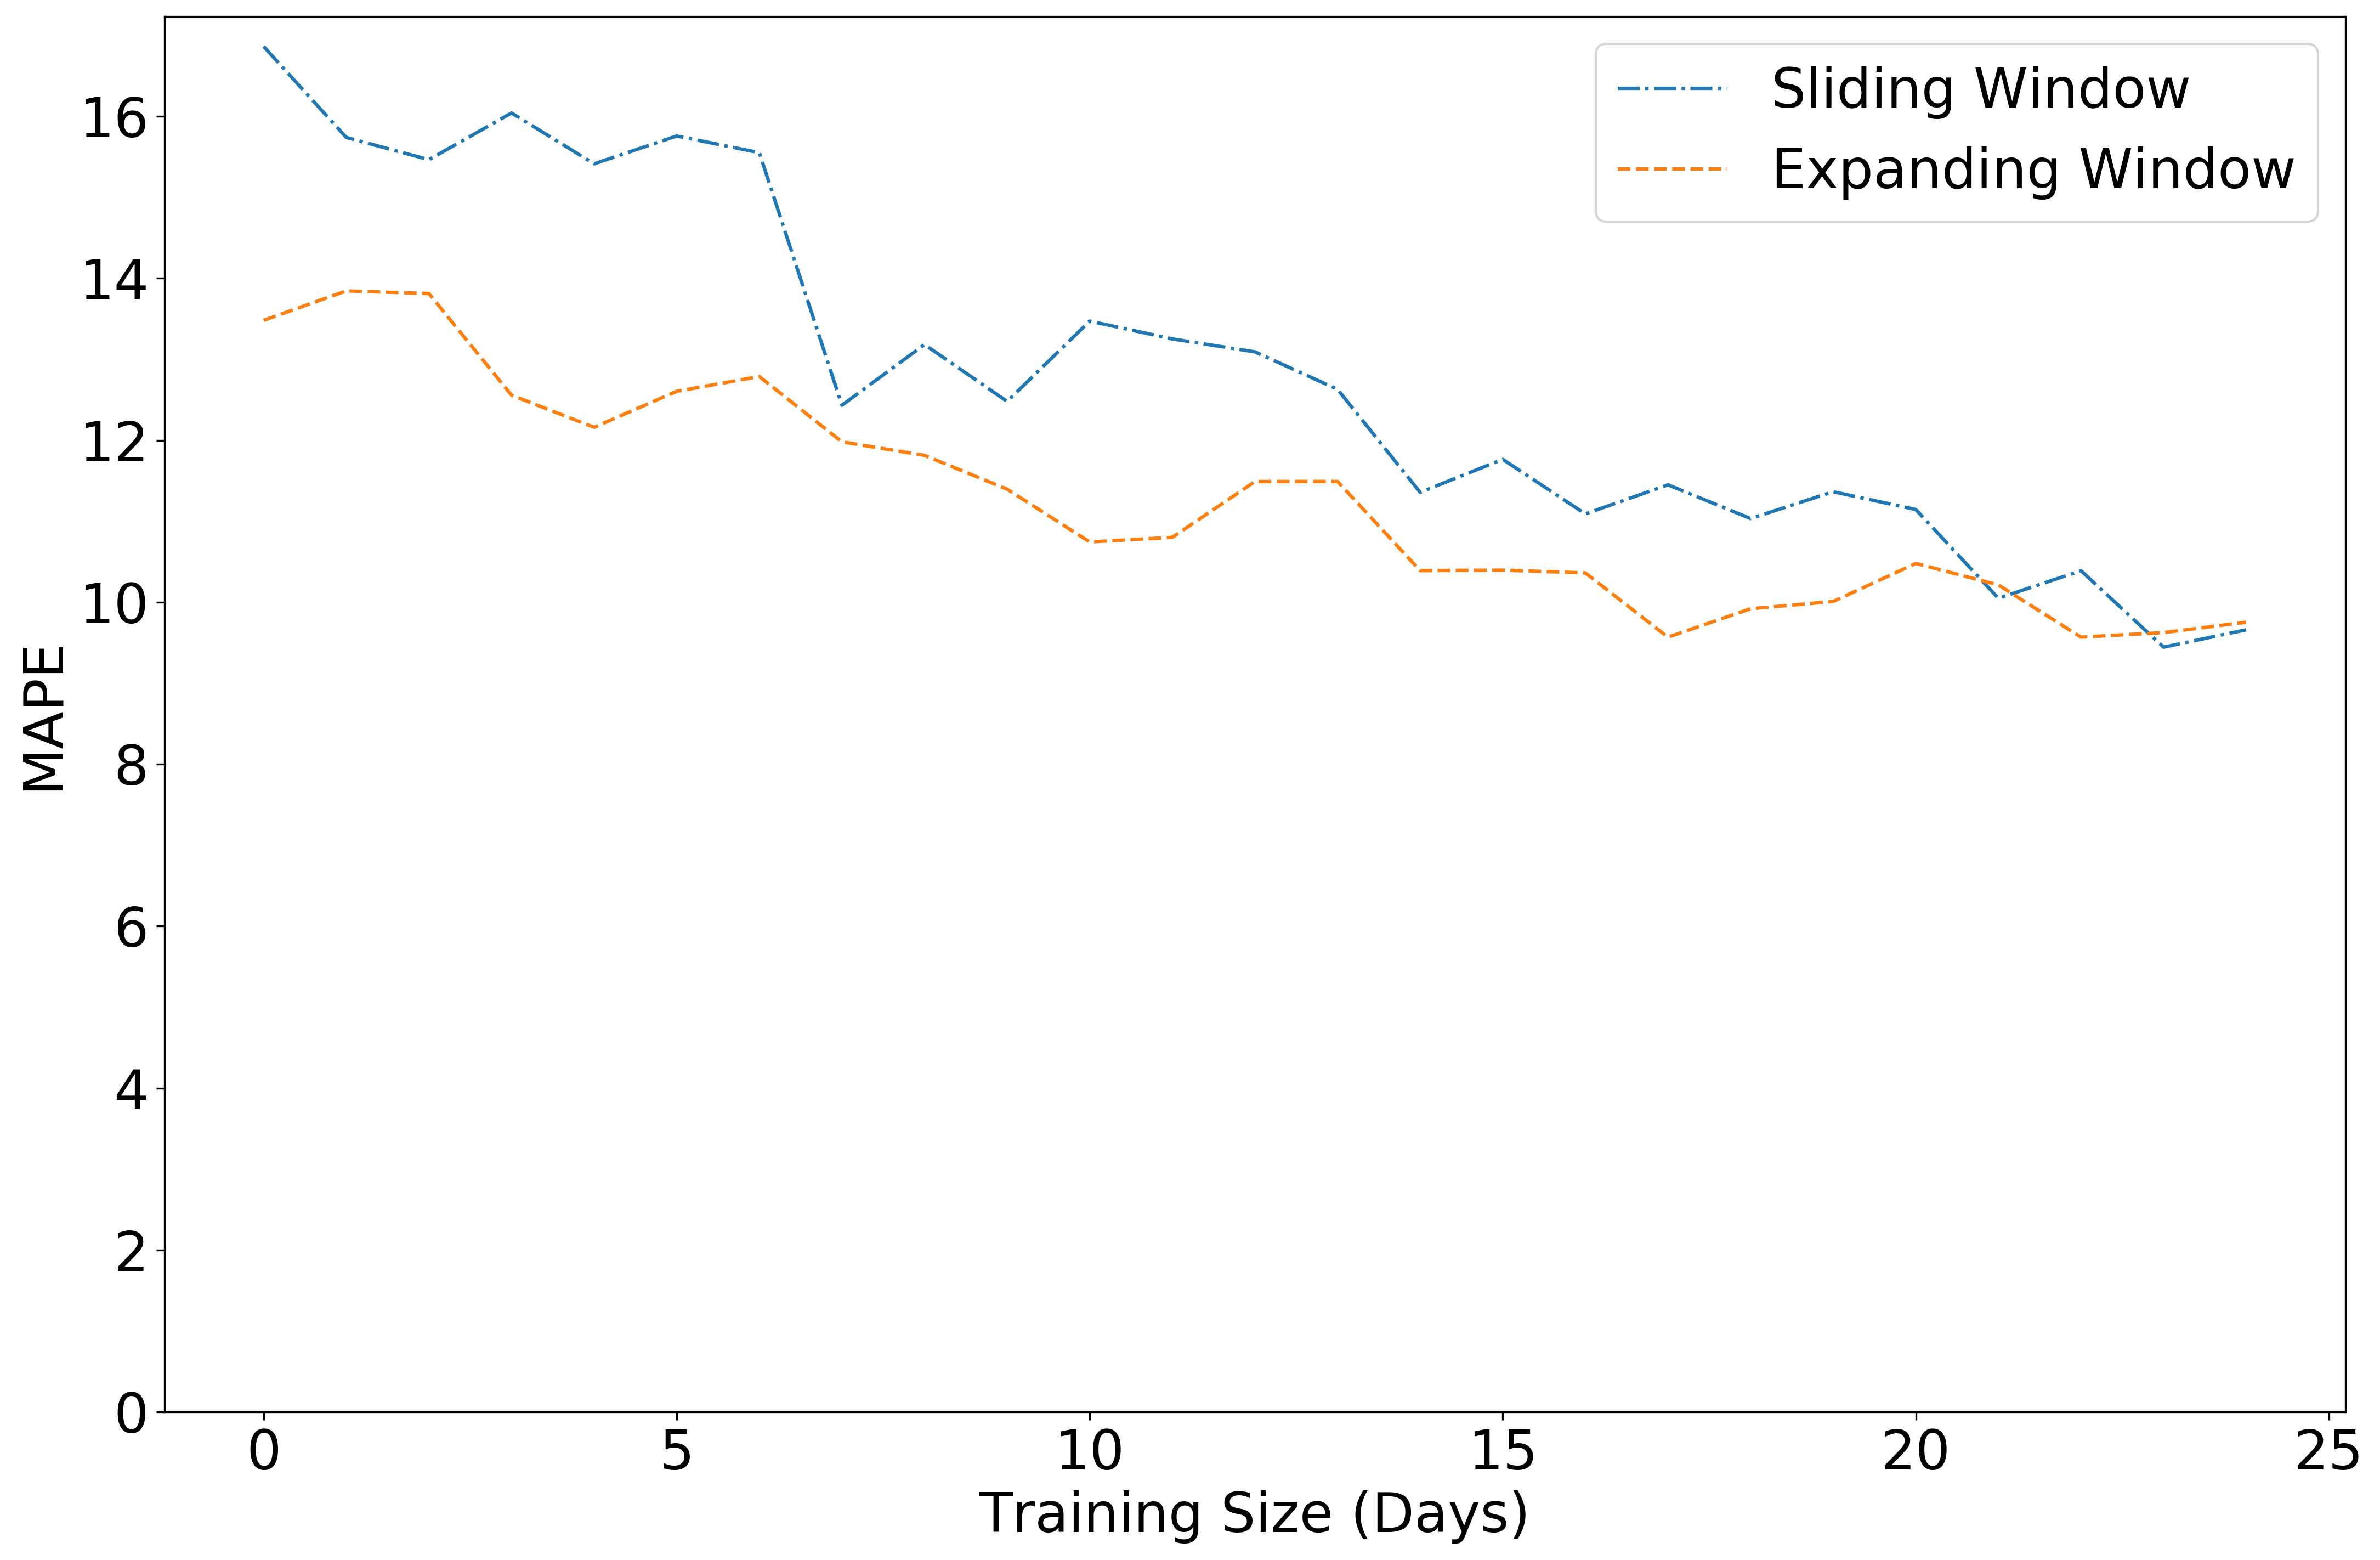

In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

font_params = {
            'font.size' : 24,
            'axes.labelsize': 24,
            'xtick.labelsize': 24,
            'ytick.labelsize': 24,
            'legend.fontsize': 24,
            'figure.dpi': 300,
            'figure.figsize': (15, 10)
            }


matplotlib.rcParams.update(font_params)

fig, ax = plt.subplots()

ax.plot(results_mape_sliding, label = 'Sliding Window', linestyle = '-.')
ax.plot(results_mape_expanding, label = 'Expanding Window', linestyle = '--')

ax.set_xlabel('Training Size (Days)')
ax.set_ylabel('MAPE')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_ylim(bottom = 0)
legend = ax.legend(loc='upper right', shadow=False)

# Save chart.
plt.savefig('charts/MAPEWindowSize.pdf')

plt.tight_layout()
plt.show()